# Diabetes Prediction Using Machine Learning

## Phase 1: Data Preprocessing for Diabetes Prediction

### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import random

### Load Dataset

In [2]:
# Load datset 
df = pd.read_csv("diabetic_data.csv")

# Display basic info
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Data Cleaning

In [3]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)
# Convert column names to lowercase & remove spaces
df.columns = df.columns.str.lower().str.replace(" ", "_")
# Drop irrelevant columns (if needed)
columns_to_drop = ["encounter_id", "patient_nbr"]  # Modify based on dataset
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
print(f"Data shape after cleaning: {df.shape}")

Data shape after cleaning: (101766, 48)


### Handling Missing Values


In [5]:
# Define target column
target_col = "readmitted"  # Change based on your dataset

# Compute missing value percentage
missing_percentage = df.isnull().sum() / len(df) * 100

# Compute correlation ONLY for numerical features
numeric_df = df.select_dtypes(include=[np.number])  # Keep only numeric columns
if target_col in numeric_df.columns:
    correlation_with_target = numeric_df.corr()[target_col].abs()
else:
    correlation_with_target = pd.Series(dtype=float)  # Empty if target is not numeric

# Drop columns with >50% missing values & low correlation
low_corr_threshold = 0.05
cols_to_drop = missing_percentage[
    (missing_percentage > 50) & (correlation_with_target.reindex(missing_percentage.index, fill_value=0) < low_corr_threshold)
].index

df.drop(columns=cols_to_drop, inplace=True)

# Impute remaining missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':  # Categorical
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:  # Numerical
            df[col].fillna(df[col].median(), inplace=True)

print(f"Dropped columns: {cols_to_drop.tolist()}")
print(f"Remaining missing values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

Dropped columns: ['max_glu_serum', 'a1cresult']
Remaining missing values:
Series([], dtype: int64)


### Outlier Detection & Handling
#### IQR Method

In [7]:
# Select only numerical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Compute IQR
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with median
for col in numeric_cols:
    df[col] = np.where((df[col] < lower_bound[col]) | (df[col] > upper_bound[col]),
                       df[col].median(), df[col])

print("Outliers handled using IQR method.")

Outliers handled using IQR method.


### Encoding Categorical Variable

In [8]:
# Label Encoding for binary categorical columns
binary_cols = ["gender"]  # Modify based on dataset
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-Hot Encoding for categorical columns
df = pd.get_dummies(df, drop_first=True)

print(f"Data shape after encoding: {df.shape}")

Data shape after encoding: (101766, 2429)


### Scaling & Normalization

In [9]:
# Choose scaling method
scaler = StandardScaler()  # or MinMaxScaler()

# Apply scaling to numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = scaler.fit_transform(df[num_cols])

print(f"Data shape after scaling: {df.shape}")

Data shape after scaling: (101766, 2429)


### Correlation Analysis

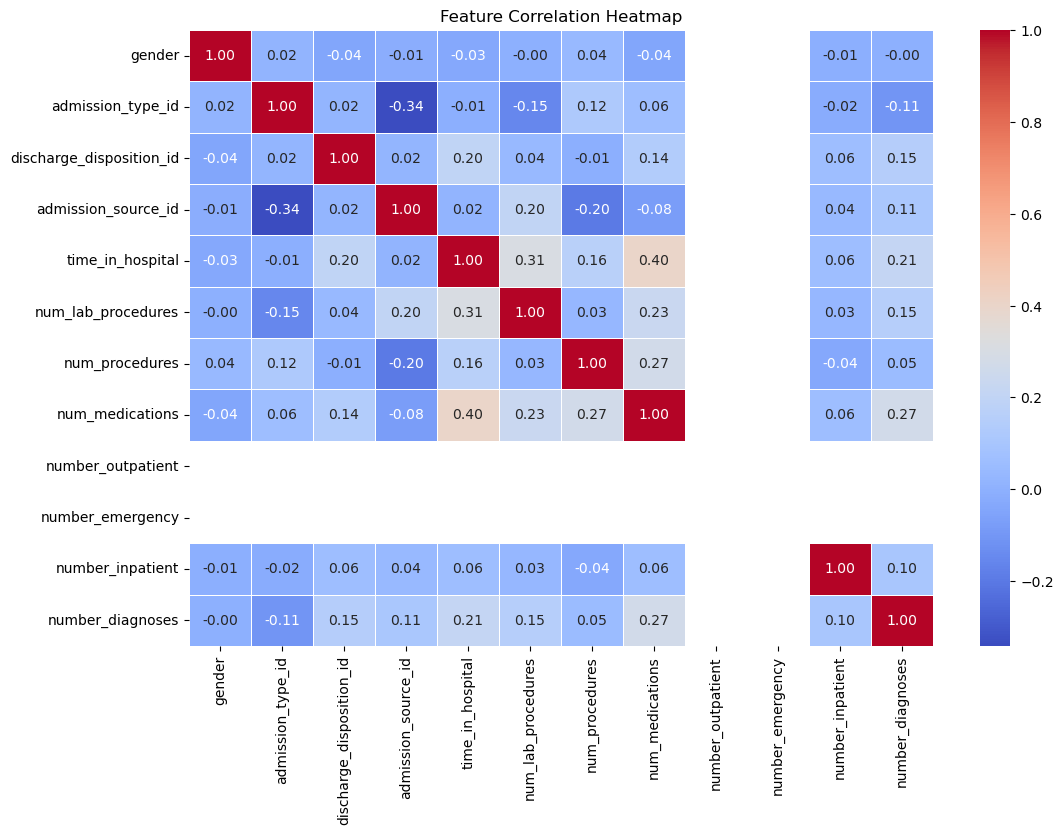

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Feature Selection

In [27]:
from sklearn.feature_selection import SelectKBest, f_classif

# Define independent (X) and dependent (y) variables
X = df[numeric_cols].drop(columns=["readmitted"], errors="ignore")  # Exclude target
y = df["readmitted"]  # Target column

# Select top K features
k = 10  # Adjust based on preference
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Top", k, "Selected Features:", list(selected_features))

KeyError: 'readmitted'

In [30]:
df.rename(columns={"readmitted_>30": "readmitted"}, inplace=True)

In [32]:
from sklearn.feature_selection import SelectKBest, f_classif

# Define independent (X) and dependent (y) variables
X = df[numeric_cols].drop(columns=["readmitted"], errors="ignore")  # Exclude target
y = df["readmitted"]  # Target column

# Select top K features
k = 10  # Adjust based on preference
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Top", k, "Selected Features:", list(selected_features))

Top 10 Selected Features: ['gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_inpatient', 'number_diagnoses']


C:\Users\sahal\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sahal\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [34]:
import random

# Define the number of random features to select
num_features = 10  # Adjust as needed

# Get all numerical feature names (excluding target column)
numeric_features = df.select_dtypes(include=[int, float]).columns.tolist()

# Ensure 'readmitted' exists before removing
if "readmitted" in numeric_features:
    numeric_features.remove("readmitted")  # Exclude target column

# Randomly select features
random_features = random.sample(numeric_features, min(num_features, len(numeric_features)))

print("Randomly Selected Features:", random_features)

Randomly Selected Features: ['time_in_hospital', 'discharge_disposition_id', 'gender', 'number_emergency', 'admission_type_id', 'num_procedures', 'number_outpatient', 'admission_source_id', 'number_inpatient', 'num_medications']


In [35]:
# Print dataset shape and first few rows
print(f"Final dataset shape: {df.shape}")
df.head()

Final dataset shape: (101766, 2429)


,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesmed_Yes,readmitted,readmitted_NO
0,-0.927397,2.845924,-0.585316,-1.498348,-1.200498,-0.103034,-0.817410,-2.127431,0.0,0.0,...,False,False,False,False,False,False,True,False,False,True
1,-0.927397,-0.712154,-0.585316,0.713010,-0.447028,0.817760,-0.817410,0.400625,0.0,0.0,...,False,False,False,False,False,False,False,True,True,False
2,-0.927397,-0.712154,-0.585316,0.713010,-0.823763,-1.637691,2.910531,-0.342921,0.0,0.0,...,False,False,False,False,False,False,True,True,False,True
3,1.078031,-0.712154,-0.585316,0.713010,-0.823763,0.050432,-0.071822,0.103206,0.0,0.0,...,False,False,False,False,False,False,False,True,False,True
4,1.078031,-0.712154,-0.585316,0.713010,-1.200498,0.408518,-0.817410,-1.086467,0.0,0.0,...,False,False,False,False,False,False,False,True,False,True
